In [1]:
%matplotlib widget

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Callable, List, Optional, Tuple
import time
RAND_SEED = 10 # good for kalman
# RAND_SEED = 12 # bad for kalman

In [2]:
# dynamics of the pendulum
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray


DT = 0.01
G = sp.constants.g


def xkp1(xk: np.ndarray) -> np.ndarray:
    return np.array([xk[0] + xk[1]*DT,
                     xk[1] - G*np.sin(xk[0])*DT])


def xkp1_vect(xk, dt=DT):
    out = np.zeros(xk.shape)
    out[:, 0] = xk[:, 0]+xk[:, 1]*dt
    out[:, 1] = xk[:, 1] - G*np.sin(xk[:, 0])*dt
    return out


def get_q() -> np.ndarray:
    QC = 0.1
    return np.array([[QC*DT**3/3, QC*DT**2/2],
                     [QC*DT**2/2, QC*DT]])


def yk(xk: np.ndarray) -> np.ndarray:
    return np.array([np.sin(xk[0])])


def yk_vect(xk):
    out = np.zeros((xk.shape[0], 1))
    out[:, 0] = np.sin(xk[:, 0])
    return out

In [3]:
# setup the problem

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]


def generate_truth(x0: np.ndarray, dt: float, N: int) -> Observations:
    times = np.zeros(N+1)  # from 0 to N times
    xk = np.zeros((N+1, 2))  # state at each time
    xk[0] = x0
    for i in range(1, N+1):
        times[i] = i*dt
        xk[i] = xkp1(xk[i-1])
    return Observations(times, np.arange(N+1), xk, [r'$x_1$ true', r'$x_2$ true'])


def generate_meas(truth: Observations, delta: float, Q: np.ndarray, R: float) -> Observations:
    process_std = np.linalg.cholesky(Q)
    measure_std = np.sqrt(R)
    measure_ind = np.arange(delta+1, truth.obs_ind[-1]+1, delta)
    obs = np.zeros((measure_ind.size, 1))
    obs_ind = 0
    for i in measure_ind:
        obs[obs_ind] = yk(truth.obs[i] +
                          np.dot(process_std, np.random.randn(2))) + measure_std*np.random.randn()
        obs_ind += 1
    return Observations(truth.times, measure_ind, obs, [r'$x_1$ obs'])


@dataclass
class MeasurementData:
    delta: float
    R: float
    obs: Observations


np.random.seed(RAND_SEED)
N = 500
X0 = np.array([1.5, 0])
prior = Gaussian(X0, np.eye(2))
Q = get_q()
proc_noise = Gaussian(np.zeros(2), Q)
proc_cov_inv = np.linalg.pinv(proc_noise.cov)
proc_cov_sqrtL = np.linalg.cholesky(proc_noise.cov)
truth = generate_truth(X0, DT, N)
deltas = [5, 10, 20, 40]
Rs = [0.001, 0.01, 0.1, 1]
data = []
for delta in deltas:
    for R in Rs:
        data.append(MeasurementData(delta, R, generate_meas(truth, delta, Q, R)))

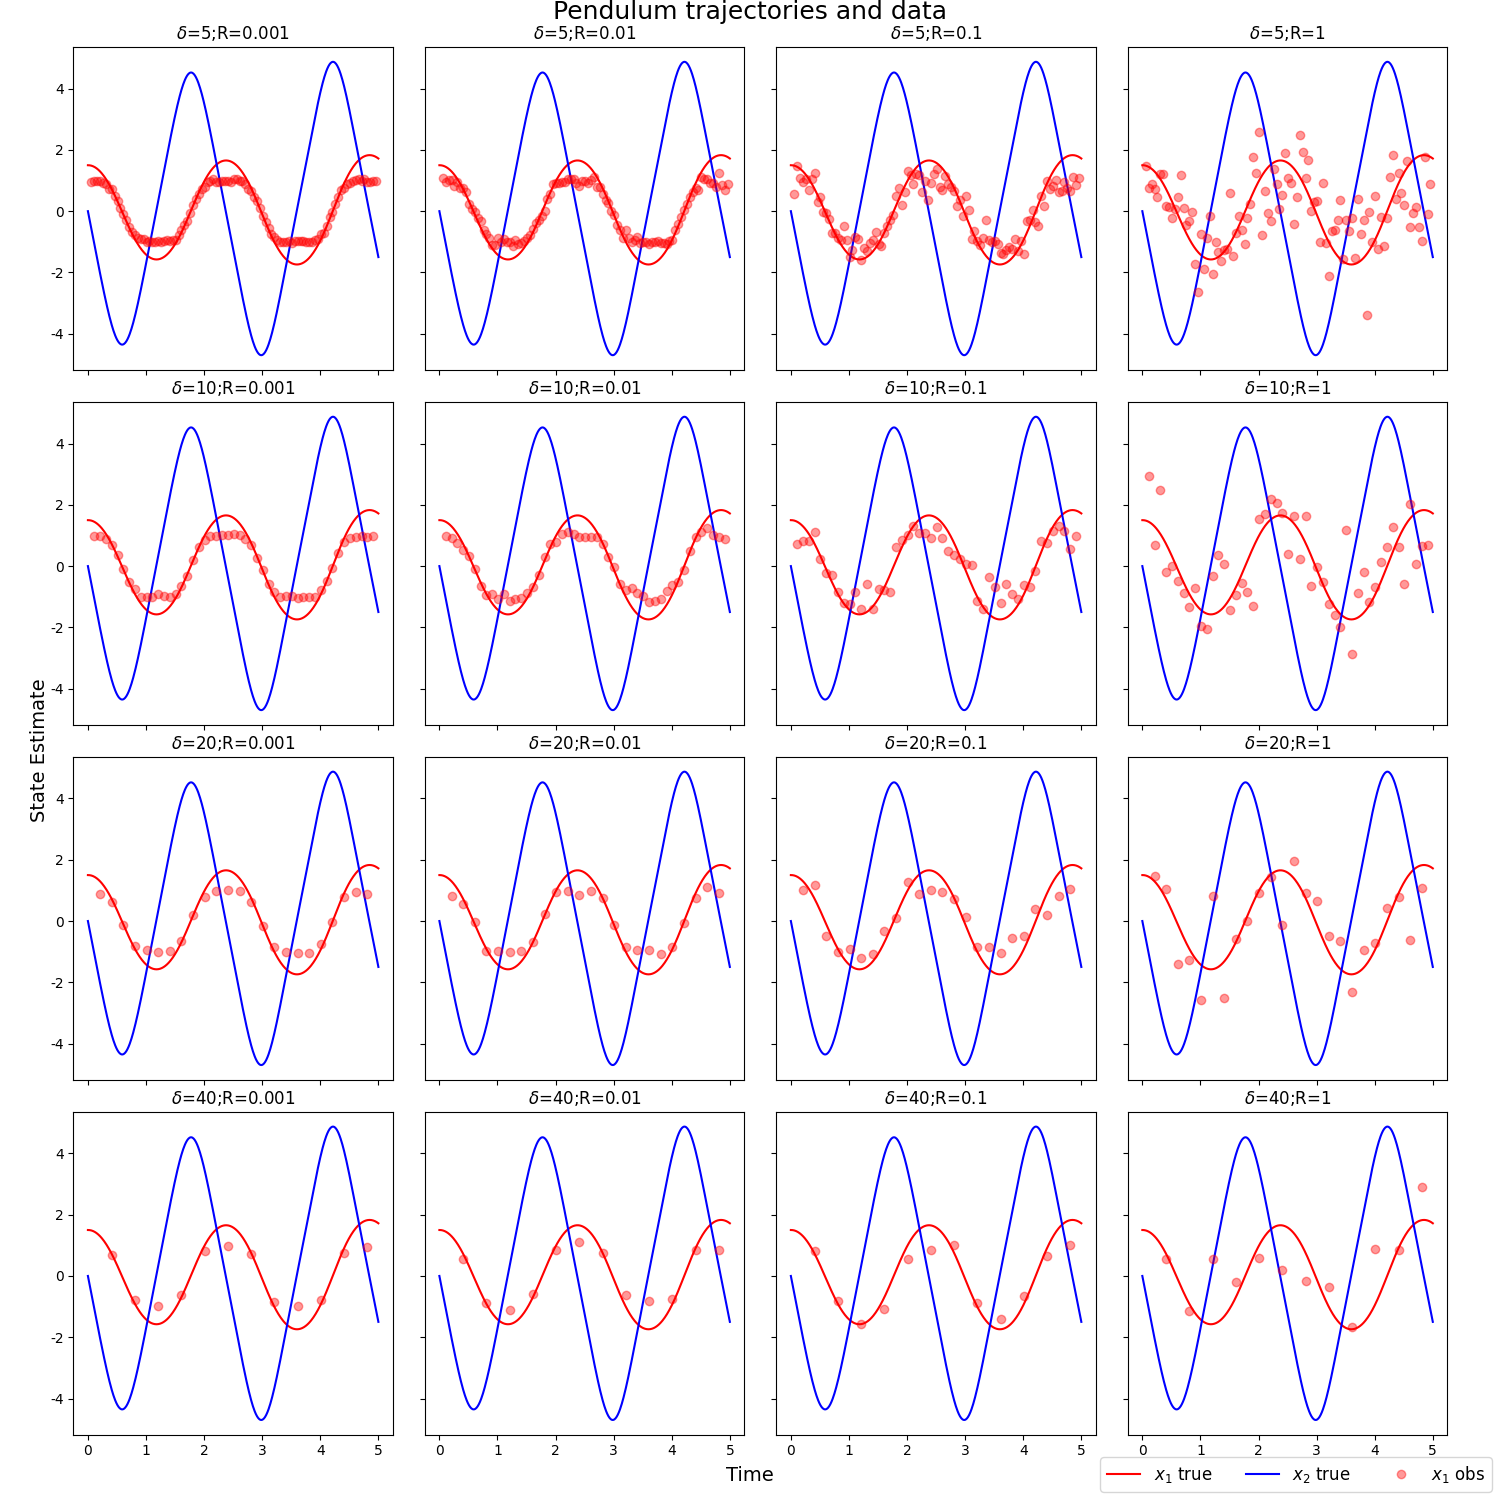

In [4]:
# setup helper functions


@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray


def plot_data_and_truth(fignum, title, true_obs: Observations, data_obs: List[MeasurementData],
                        kft: Optional[List[KFTracker]] = None) -> plt.figure:

    colors = ['red', 'blue']
    plt.close(fignum)
    fig, axs = plt.subplots(4, 4, num=fignum, figsize=(15, 15), sharex=True, sharey=True)
    fig.tight_layout(pad=3)
    fig.suptitle(title, fontsize=18, y=1.0)
    for i in range(len(data_obs)):
        ax = axs[i//4, i % 4]
        ax.plot(true_obs.times, true_obs.obs[:, 0], color=colors[0], label=true_obs.names[0])
        ax.plot(true_obs.times, true_obs.obs[:, 1], color=colors[1], label=true_obs.names[1])

        if kft is not None:
            ax.plot(data_obs[i].obs.times, kft[i].means[:, 0],
                    '--', color=colors[0], label=r'$x_1$ est')
            ax.plot(data_obs[i].obs.times, kft[i].means[:, 1],
                    '--', color=colors[1], label=r'$x_2$ est')
            ax.fill_between(data_obs[i].obs.times,
                            kft[i].means[:, 0] - 2 * kft[i].stds[:, 0],
                            kft[i].means[:, 0] + 2 * kft[i].stds[:, 0],
                            color=colors[0], alpha=0.3)
            ax.fill_between(data_obs[i].obs.times,
                            kft[i].means[:, 1] - 2 * kft[i].stds[:, 1],
                            kft[i].means[:, 1] + 2 * kft[i].stds[:, 1],
                            color=colors[1], alpha=0.3)
            ax.set_title(
                r'$\delta$=' +
                f'{data_obs[i].delta};R={data_obs[i].R};MSE={mean_sq_error(true_obs, kft[i]):.3f}',
                fontsize=12)
        else:
            ax.set_title(r'$\delta$='+f'{data_obs[i].delta};R={data_obs[i].R}', fontsize=12)

        ax.plot(data_obs[i].obs.times[data_obs[i].obs.obs_ind], data_obs[i].obs.obs,
                'o', color=colors[0], alpha=0.4, label=data_obs[i].obs.names[0])

        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))

    h, l = axs[0, 0].get_legend_handles_labels()
    fig.legend(h, l, loc='lower right', fontsize=12, ncol=3)
    fig.supxlabel('Time', fontsize=14)
    fig.supylabel('State Estimate', fontsize=14)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.savefig(f'figs/{title}.svg')
    plt.show()
    return fignum + 1


def mean_sq_error(truth: Observations, results: KFTracker) -> float:
    return np.mean((truth.obs - results.means)**2)


def print_mean_sq_error(truth: Observations, results: KFTracker, data: list[MeasurementData]) -> float:
    for result, obs in zip(results, data):
        mse = mean_sq_error(truth, result)
        print(f'delta={obs.delta} \tR={obs.R}\tMSE={mse:.1e}')


fignum = 1

fignum = plot_data_and_truth(fignum, 'Pendulum trajectories and data', truth, data)

In [5]:

# linearized dynamics


def Ak(xk: np.ndarray) -> np.ndarray:
    return np.array([[1, DT],
                     [-G*np.cos(xk[0])*DT, 1]])


def Hk(xk: np.ndarray) -> np.ndarray:
    return np.array([[np.cos(xk[0]), 0]]).reshape(1, 2)

# extended kalman filter


def ekf_predict(phi: Callable[[np.ndarray], np.ndarray], A: np.ndarray,
                X: Gaussian, xi: Gaussian) -> Gaussian:
    """Linear Prediction Step: Propagate uncertainty for one time step.

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{noise_mean, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    phi: dynamics function
    A: (d, d), linearized dynamics
    X: Gaussian
    xi: Gaussian

    Returns
    -------
    A Gaussian random variable for the next time step
    """

    pred_mean = phi(X.mean) + xi.mean
    pred_cov = np.dot(A, np.dot(X.cov, A.T)) + xi.cov
    return Gaussian(pred_mean, pred_cov)


def ekf_update(data: np.ndarray, h: Callable[[np.ndarray], np.ndarray], H: np.ndarray,
               X: Gaussian, eta: Gaussian) -> Gaussian:
    """Linear Gaussian Inverse Problem.

    Inputs
    ------
    data: (N) array of data
    h: observation function
    H: (m, d), linearized observation model
    X: Gaussian
    eta: Gaussian

    Returns
    -------
    Gaussian Posterior
    """
    mu = h(X.mean) + eta.mean
    U = np.dot(X.cov, H.T)
    S = np.dot(H, U) + eta.cov

    update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)


def extended_kalman_filter(data: Observations,
                           phi: Callable[[np.ndarray], np.ndarray],
                           A: Callable[[np.ndarray], np.ndarray],
                           h: Callable[[np.ndarray], np.ndarray],
                           H: Callable[[np.ndarray], np.ndarray],
                           prior: Gaussian,
                           xi: Gaussian, eta: Gaussian) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    phi: dynamics function
    A: linearized dynamics function
    h: observation function
    H: linearized observation function
    prior: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    KFTracker
    """

    num_steps = data.times.shape[0]

    d = prior.mean.shape[0]
    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(prior.mean)
    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(prior.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    # Loop over all time steps
    Xnext = prior
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = ekf_predict(phi, A(Xnext.mean), Xnext, xi)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = ekf_update(y, h, H(Xpred.mean), Xpred, eta)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, :, :] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

In [6]:
# unscented kalman filter of order 3

def unscented_points(X: Gaussian, alg: str = 'chol', alpha: float = 1,
                     beta: float = 0, kappa: float = 0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Generate unscented points"""
    dim = X.cov.shape[0]
    lam = alpha*alpha*(dim + kappa) - dim
    if alg == "chol":
        L = np.linalg.cholesky(X.cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(X.cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
    pts = np.zeros((2*dim+1, dim))
    pts[0, :] = X.mean
    for ii in range(1, dim+1):
        pts[ii, :] = X.mean + np.sqrt(dim + lam)*L[:, ii-1]
        pts[ii+dim, :] = X.mean - np.sqrt(dim + lam)*L[:, ii-1]
    w_m = np.zeros((2*dim+1, 1))  # just 1 weight per point
    w_c = np.zeros((2*dim+1, 1))  # just 1 weight per point
    w_m[0] = lam / (dim + lam)
    w_m[1:] = 1/2 / (dim + lam)
    w_c[0] = lam / (dim + lam) + (1 - alpha*alpha + beta)
    w_c[1:] = 1/2 / (dim + lam)
    return pts, w_m, w_c


def ukf_predict(phi: Callable[[np.ndarray], np.ndarray], X: Gaussian, xi: Gaussian,
                alpha: float = 1, beta: float = 0, kappa: float = 0) -> Gaussian:
    """Prediction Step: Propagate uncertainty for one time step.

    Inputs
    ------
    phi: dynamics function
    X: Gaussian
    xi: Gaussian

    Returns
    -------
    A Gaussian random variable for the next time step
    """

    dims_x = X.mean.shape[0]
    u, w_m, w_c = unscented_points(X, alpha=alpha, beta=beta, kappa=kappa)
    num_u = u.shape[0]

    # pred_mean = phi(X.mean) + xi.mean
    pred_state = phi(u)
    pred_mean = np.sum(pred_state * w_m, axis=0)

    # pred_cov = np.dot(A, np.dot(X.cov, A.T)) + xi.cov
    pred_cov = np.zeros((dims_x, dims_x)) + xi.cov
    std_state = pred_state - pred_mean
    for i in range(num_u):
        pred_cov += np.outer(std_state[i, :], std_state[i, :]) * w_c[i]

    return Gaussian(pred_mean, pred_cov)


def ukf_update(data: np.ndarray, h: Callable[[np.ndarray], np.ndarray], X: Gaussian,
               eta: Gaussian, alpha: float = 1, beta: float = 0, kappa: float = 0) -> Gaussian:
    """Gaussian Inverse Problem

    Inputs
    ------
    data: (N) array of data
    h: observation function
    X: Gaussian
    eta: Gaussian

    Returns
    -------
    Gaussian Posterior
    """

    dims_x = X.mean.shape[0]
    dims_data = 1
    u, w_m, w_c = unscented_points(X, alpha=alpha, beta=beta, kappa=kappa)
    num_u = u.shape[0]

    # mu = h(X.mean) + eta.mean
    pred_meas = h(u)
    mu = np.sum(pred_meas * w_m, axis=0)

    # U = np.dot(X.cov, H.T)
    std_state = u - X.mean
    std_meas = pred_meas - mu
    U = np.zeros((dims_x, dims_data))
    for i in range(num_u):
        U += np.outer(std_state[i, :], std_meas[i, :]) * w_c[i]

    # S = np.dot(H, U) + eta.cov
    S = np.zeros((dims_data, dims_data)) + eta.cov
    for i in range(num_u):
        S += np.outer(std_meas[i, :], std_meas[i, :]) * w_c[i]

    update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)


def unscented_kalman_filter(data: Observations,
                            phi: Callable[[np.ndarray], np.ndarray],
                            h: Callable[[np.ndarray], np.ndarray],
                            prior: Gaussian,
                            xi: Gaussian, eta: Gaussian,
                            alpha: float = 1, beta: float = 0, kappa: float = 0) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    phi: dynamics function
    h: observation function
    prior: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    KFTracker
    """

    num_steps = data.times.shape[0]

    d = prior.mean.shape[0]
    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(prior.mean)
    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(prior.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    # Loop over all time steps
    Xnext = prior
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = ukf_predict(phi, Xnext, xi, alpha, beta, kappa)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = ukf_update(y, h, Xpred, eta, alpha, beta, kappa)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, :, :] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

In [7]:
# gaus-hermite kalman filter

def gh_oned(num_pts=2):
    """Gauss-hermite quadrature in 1D"""
    A = np.zeros((num_pts, num_pts))
    for ii in range(num_pts):
        # print("ii ", ii, ii==0, ii==(order-1))
        row = ii+1
        if ii == 0:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
        elif ii == (num_pts-1):
            A[ii-1, ii] = np.sqrt(ii)
        else:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
    pts, evec = np.linalg.eig(A)
    devec = np.dot(evec.T, evec)
    wts = evec[0, :]**2

    return pts, wts


def tensorize(nodes):
    """Tensorize nodes to obtain twod"""
    n1d = nodes.shape[0]
    twodnodes = np.zeros((n1d*n1d, 2))
    ind = 0
    for ii in range(n1d):
        for jj in range(n1d):
            twodnodes[ind, :] = np.array([nodes[ii], nodes[jj]])
            ind += 1
    return twodnodes


def gauss_hermite(dim, num_pts=2):
    """Gauss-hermite quadrature in 2D"""
    assert dim == 2, "Tensorize only implemented for dim=2"
    pts, weights = gh_oned(num_pts)
    ptsT = tensorize(pts)
    weightsT = tensorize(weights)
    weightsT = np.prod(weightsT, axis=1)
    return ptsT, weightsT.reshape(-1, 1)  # reshape so theyre column vectors like ptsT


def rotate_points(points: int, X: Gaussian, alg: str = "chol"):
    """Rotating points from standard gaussian to target Gaussian"""
    if alg == "chol":
        L = np.linalg.cholesky(X.cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(X.cov)
        L = np.dot(u, np.sqrt(np.diag(s)))

    new_points = np.zeros(points.shape)
    for ii in range(points.shape[0]):
        new_points[ii, :] = X.mean + np.dot(L, points[ii, :].T)
    return new_points


def ghkf_predict(phi: Callable[[np.ndarray], np.ndarray], X: Gaussian,
                 xi: Gaussian, order: int) -> Gaussian:
    """Prediction Step: Propagate uncertainty for one time step.

    Inputs
    ------
    phi: dynamics function
    X: Gaussian
    xi: Gaussian

    Returns
    -------
    A Gaussian random variable for the next time step
    """

    dims_x = X.mean.shape[0]
    u, w = gauss_hermite(dims_x, num_pts=order)  # get points from std gauss
    u = rotate_points(u, X)  # rotate points to target Gaussian
    num_u = u.shape[0]

    # pred_mean = phi(X.mean) + xi.mean
    pred_state = phi(u)
    pred_mean = np.sum(pred_state * w, axis=0)

    # pred_cov = np.dot(A, np.dot(X.cov, A.T)) + xi.cov
    pred_cov = np.zeros((dims_x, dims_x)) + xi.cov
    std_state = pred_state - pred_mean
    for i in range(num_u):
        pred_cov += np.outer(std_state[i, :], std_state[i, :]) * w[i]

    return Gaussian(pred_mean, pred_cov)


def ghkf_update(data: np.ndarray, h: Callable[[np.ndarray], np.ndarray],
                X: Gaussian, eta: Gaussian, order: int) -> Gaussian:
    """Gaussian Inverse Problem

    Inputs
    ------
    data: (N) array of data
    h: observation function
    X: Gaussian
    eta: Gaussian

    Returns
    -------
    Gaussian Posterior
    """

    dims_x = X.mean.shape[0]
    dims_data = 1
    u, w = gauss_hermite(dims_x, num_pts=order)  # get points from std gauss
    u = rotate_points(u, X)  # rotate points to target Gaussian
    num_u = u.shape[0]

    # mu = h(X.mean) + eta.mean
    pred_meas = h(u)
    mu = np.sum(pred_meas * w, axis=0)

    # U = np.dot(X.cov, H.T)
    std_state = u - X.mean
    std_meas = pred_meas - mu
    U = np.zeros((dims_x, dims_data))
    for i in range(num_u):
        U += np.outer(std_state[i, :], std_meas[i, :]) * w[i]

    # S = np.dot(H, U) + eta.cov
    S = np.zeros((dims_data, dims_data)) + eta.cov
    for i in range(num_u):
        S += np.outer(std_meas[i, :], std_meas[i, :]) * w[i]

    update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)


def gauss_hermite_kalman_filter(data: Observations,
                                phi: Callable[[np.ndarray], np.ndarray],
                                h: Callable[[np.ndarray], np.ndarray],
                                prior: Gaussian,
                                xi: Gaussian, eta: Gaussian,
                                order: int) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    phi: dynamics function
    h: observation function
    prior: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    KFTracker
    """

    num_steps = data.times.shape[0]

    d = prior.mean.shape[0]
    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(prior.mean)
    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(prior.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    # Loop over all time steps
    Xnext = prior
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = ghkf_predict(phi, Xnext, xi, order)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = ghkf_update(y, h, Xpred, eta, order)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, :, :] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

** Timing
EKF:	0.173 s
UKF:	0.659 s
GHKF 3:	1.436 s
GHKF 5:	2.763 s
** Mean Squared Error
EKF:
delta=5 	R=0.001	MSE=5.0e-02
delta=5 	R=0.01	MSE=2.8e-02
delta=5 	R=0.1	MSE=6.4e-02
delta=5 	R=1	MSE=9.4e-02
delta=10 	R=0.001	MSE=1.0e-02
delta=10 	R=0.01	MSE=1.7e-02
delta=10 	R=0.1	MSE=1.7e-02
delta=10 	R=1	MSE=1.1e+00
delta=20 	R=0.001	MSE=2.4e-02
delta=20 	R=0.01	MSE=5.3e-02
delta=20 	R=0.1	MSE=1.5e-01
delta=20 	R=1	MSE=1.0e+00
delta=40 	R=0.001	MSE=4.5e-03
delta=40 	R=0.01	MSE=2.9e-02
delta=40 	R=0.1	MSE=7.8e-01
delta=40 	R=1	MSE=1.4e+00
delta=5 	R=0.001	MSE=1.0e-01
delta=5 	R=0.01	MSE=1.3e-01
delta=5 	R=0.1	MSE=1.4e-01
delta=5 	R=1	MSE=5.0e-01
delta=10 	R=0.001	MSE=1.3e-01
delta=10 	R=0.01	MSE=1.2e-01
delta=10 	R=0.1	MSE=1.5e-01
delta=10 	R=1	MSE=5.0e-01
delta=20 	R=0.001	MSE=1.4e-01
delta=20 	R=0.01	MSE=1.3e-01
delta=20 	R=0.1	MSE=1.9e-01
delta=20 	R=1	MSE=5.5e-01
delta=40 	R=0.001	MSE=1.5e-01
delta=40 	R=0.01	MSE=1.8e-01
delta=40 	R=0.1	MSE=4.8e-01
delta=40 	R=1	MSE=1.9e+00
delta=5 	

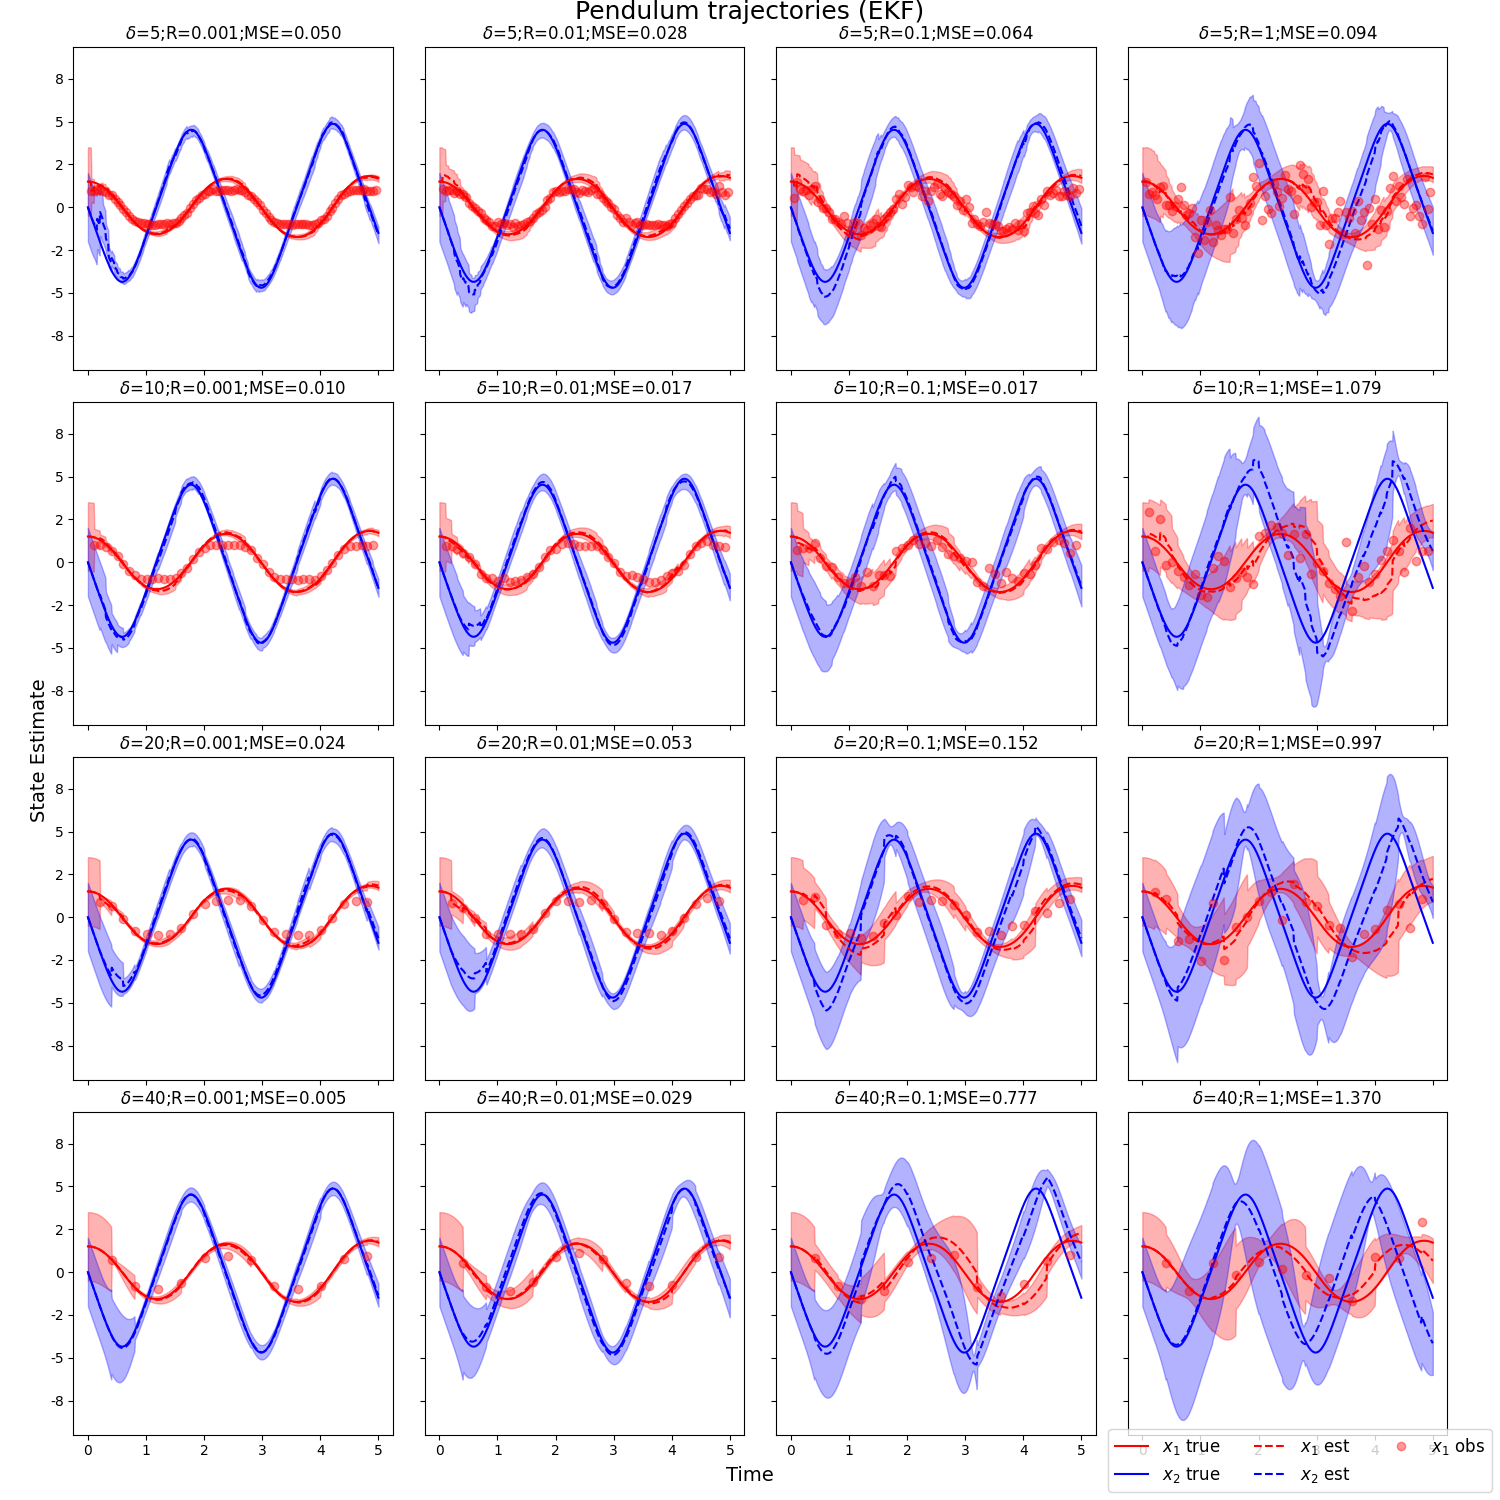

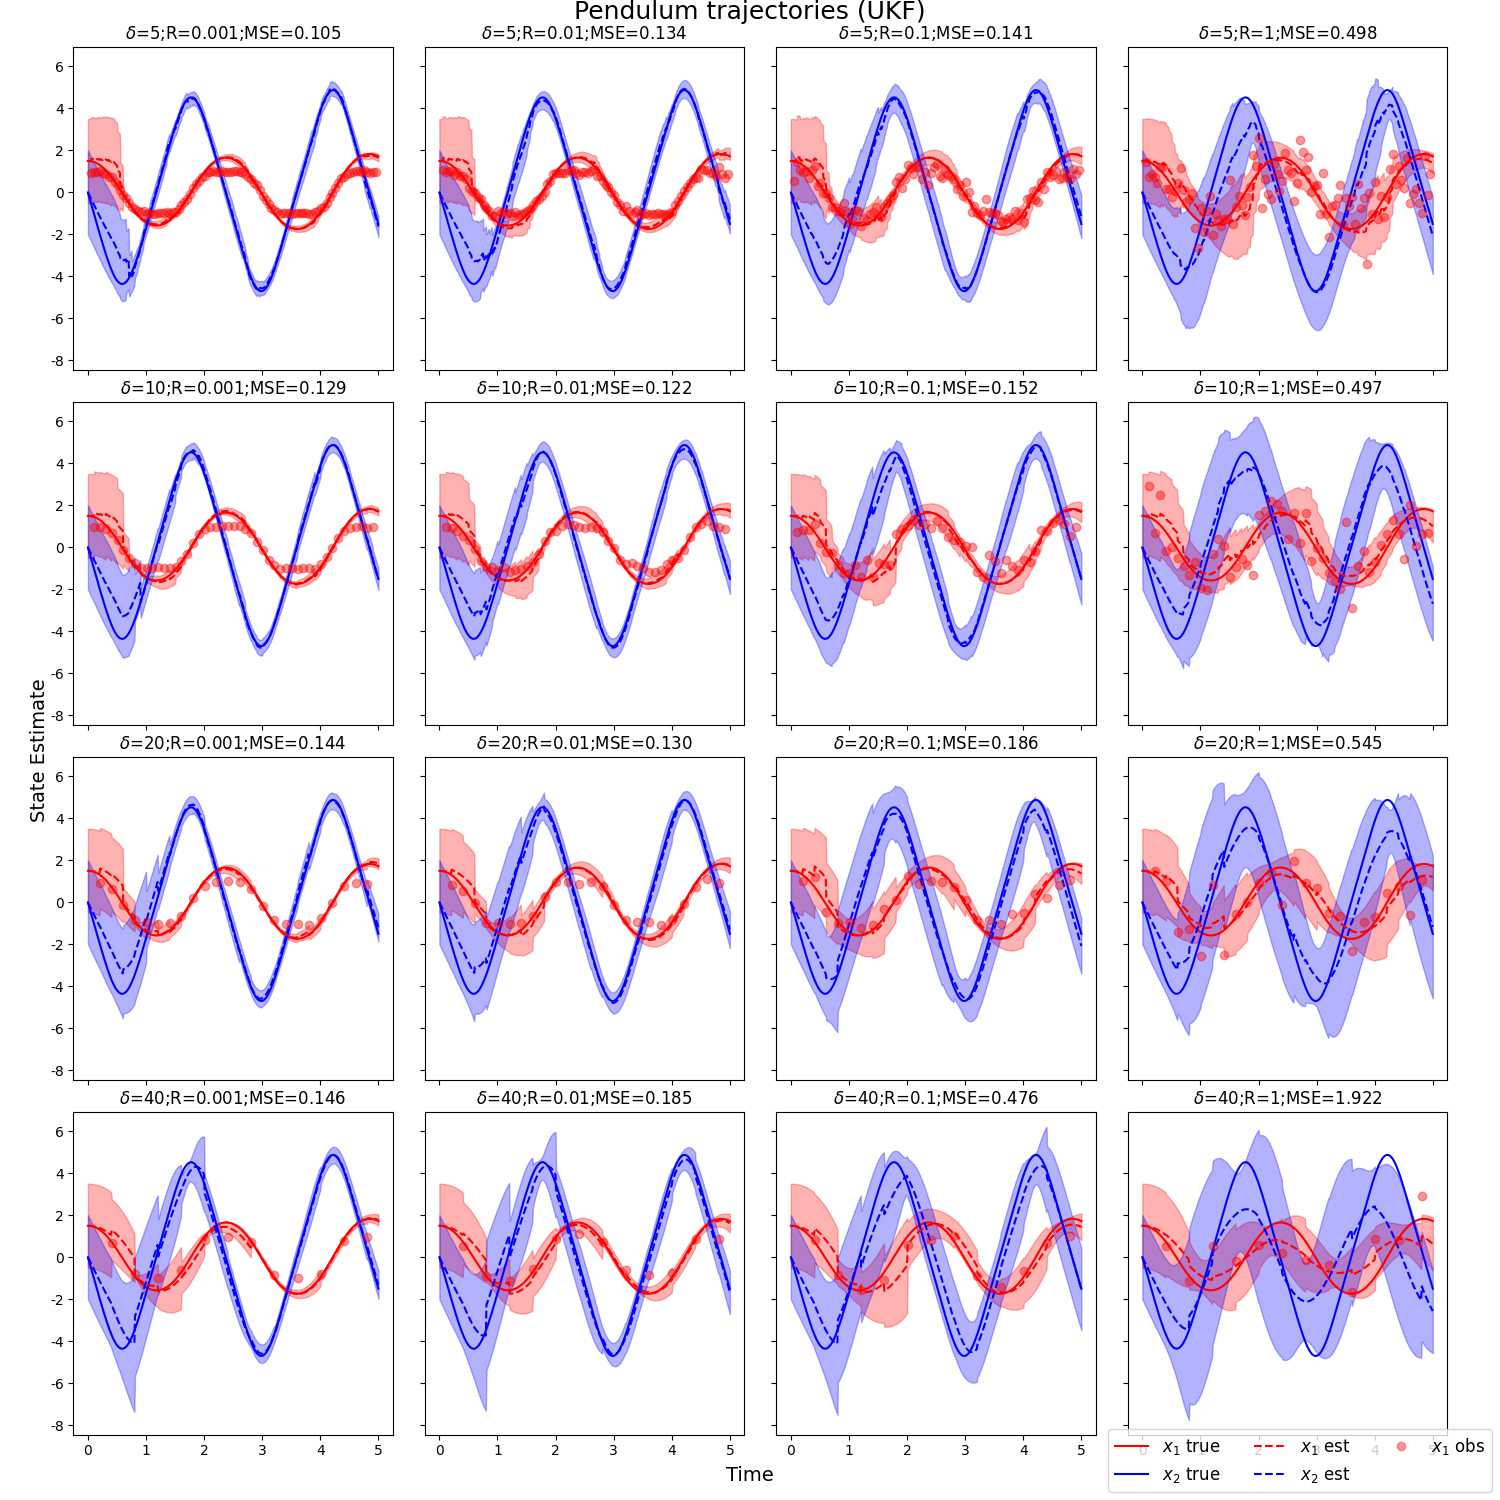

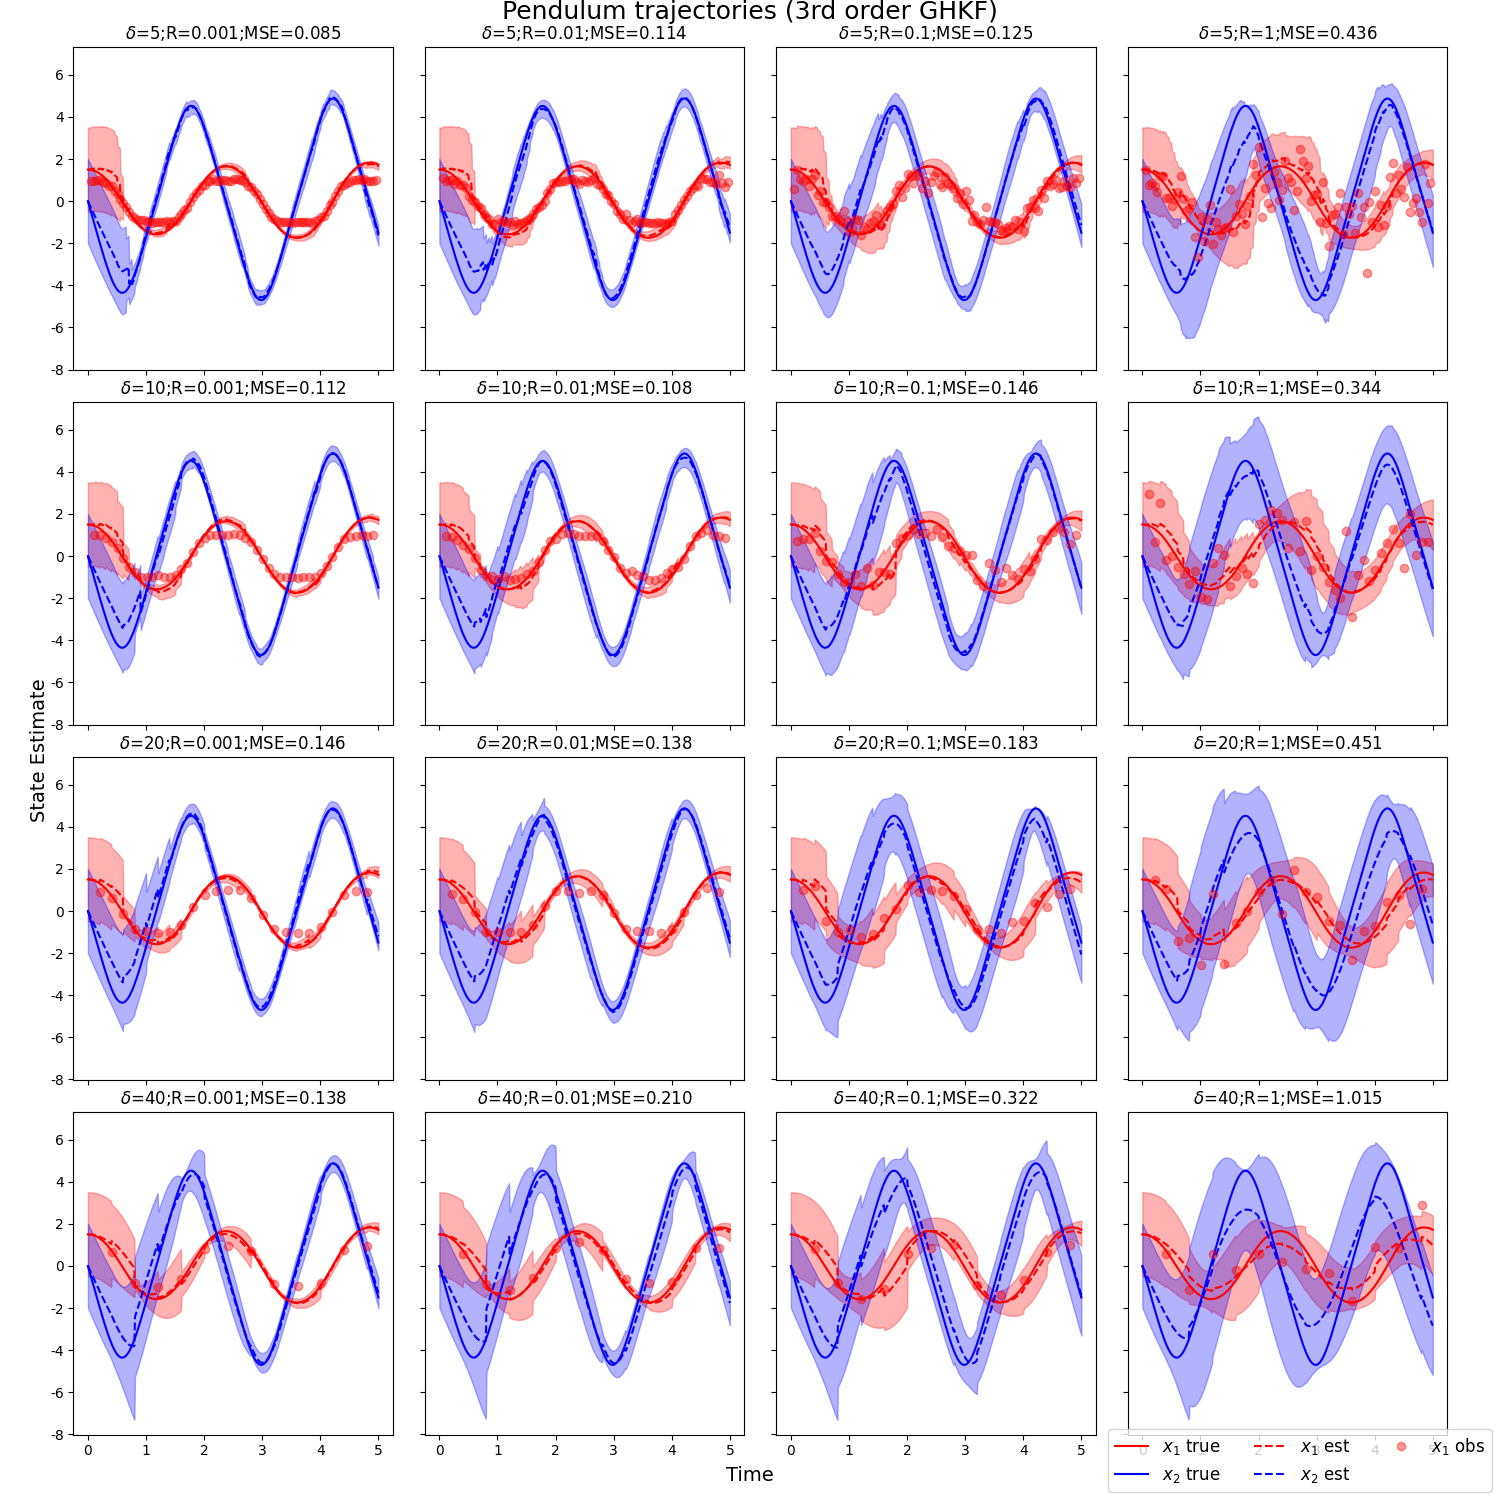

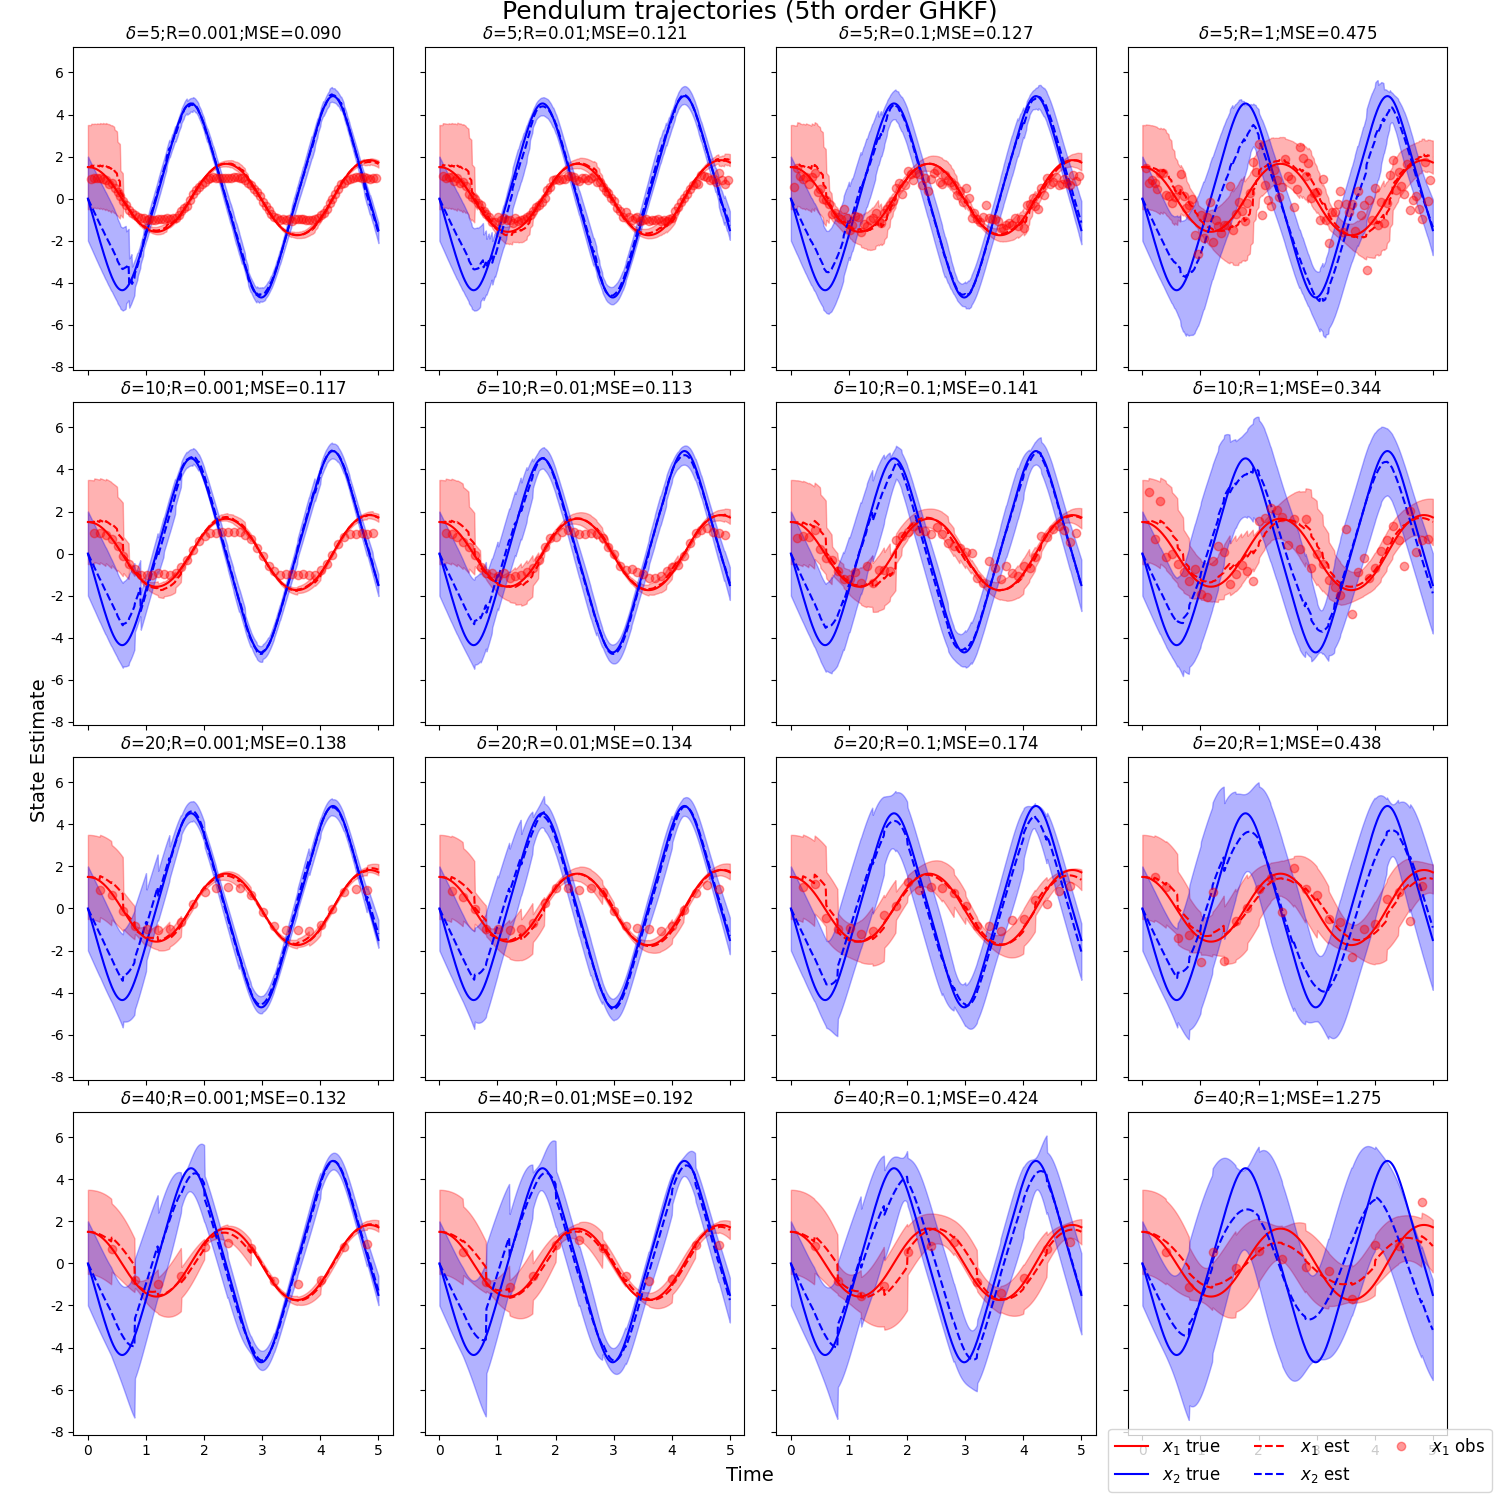

In [8]:
# run all the kalma filters

np.random.seed(RAND_SEED)
ekf_results = []
ekf_start = time.time()
for obs in data:
    ekf_results.append(extended_kalman_filter(obs.obs, xkp1, Ak, yk,
                       Hk, prior, proc_noise, Gaussian(0, obs.R)))
ekf_time = time.time() - ekf_start

np.random.seed(RAND_SEED)
ukf_results = []
ukf_start = time.time()
for obs in data:
    ukf_results.append(unscented_kalman_filter(obs.obs, xkp1_vect,
                       yk_vect, prior, proc_noise, Gaussian(0, obs.R)))
ukf_time = time.time() - ukf_start

np.random.seed(RAND_SEED)
ghkf3_results = []
ghkf3_start = time.time()
for obs in data:
    ghkf3_results.append(gauss_hermite_kalman_filter(obs.obs, xkp1_vect,
                                                     yk_vect, prior, proc_noise, Gaussian(0, obs.R), 3))
ghkf3_time = time.time() - ghkf3_start

np.random.seed(RAND_SEED)
ghkf5_results = []
ghkf5_start = time.time()
for obs in data:
    ghkf5_results.append(gauss_hermite_kalman_filter(obs.obs, xkp1_vect,
                                                     yk_vect, prior, proc_noise, Gaussian(0, obs.R), 5))
ghkf5_time = time.time() - ghkf5_start


print('** Timing')
print(f'EKF:\t{ekf_time:.3f} s')
print(f'UKF:\t{ukf_time:.3f} s')
print(f'GHKF 3:\t{ghkf3_time:.3f} s')
print(f'GHKF 5:\t{ghkf5_time:.3f} s')

print('** Mean Squared Error')
print(f"EKF:")
print_mean_sq_error(truth, ekf_results, data)
print_mean_sq_error(truth, ukf_results, data)
print_mean_sq_error(truth, ghkf3_results, data)
print_mean_sq_error(truth, ghkf5_results, data)

# plots
fignum = plot_data_and_truth(fignum, 'Pendulum trajectories (EKF)', truth, data, ekf_results)
fignum = plot_data_and_truth(fignum, 'Pendulum trajectories (UKF)', truth, data, ukf_results)
fignum = plot_data_and_truth(
    fignum, 'Pendulum trajectories (3rd order GHKF)', truth, data, ghkf3_results)
fignum = plot_data_and_truth(
    fignum, 'Pendulum trajectories (5th order GHKF)', truth, data, ghkf5_results)

In [9]:
# particle filter

def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*

    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights

    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = samples.shape[0]  # get number of points that make up the empirical distribution
    rr = np.arange(N)  # get an ordered set of numbers from 0 to N-1

    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(rr, Nsamples, p=weights)

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]

    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out


def step(prop, proppdf, current_samples, current_weights, likelihood, data, propagator):
    """
    Propagate a particle filter

    Inputs
    --------
    prop            - proposal function (current_state, data)
    proppdf         - proposal function logpdf
    current_samples - ensemble of samples
    current_weights - ensemble of weights
    likelihood      - function to evaluate the log likelihood (samples, data)
    data            - Observation
    propagator      - dynamics logpdf

    @returns samples and weights after assimilating the data
    """

    new_samples = prop(current_samples, data)
    new_weights = likelihood(new_samples, data) + propagator(new_samples, current_samples) - \
        proppdf(new_samples, current_samples, data)
    new_weights = np.exp(new_weights) * current_weights

    # normalize weights
    new_weights = new_weights / np.sum(new_weights)
    return new_samples, new_weights


@dataclass
class PFResults:
    delta: float
    R: float
    samples: np.ndarray
    weights: np.ndarray
    eff: np.ndarray


def particle_filter(data, prior, prop, proppdf, likelihood, propagator,
                    nsamples=1000, resampling_threshold_frac=0.1):
    """Particle Filter

    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size

    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """

    d = prior.mean.shape[0]
    nsteps = data.times.shape[0]

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps))
    weights = np.zeros((nsamples, nsteps))
    eff = np.zeros((nsteps))  # keep track of effective sample size at each step

    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior.cov)
    samples[:, :, 0] = np.tile(prior.mean, (nsamples, 1)) + \
        np.dot(L, np.random.randn(d, nsamples)).T
    # all weights are equal because of independent sampling from prior
    weights[:, 0] = 1.0 / nsamples
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    on_obs = 0

    for ii in range(1, nsteps):
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                     likelihood, data.obs[on_obs, :], propagator)
            on_obs += 1
        else:
            samples[:, :, ii] = dyn_prop(samples[:, :, ii-1])
            weights[:, ii] = weights[:, ii-1]

        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)

        if ii % 50 == 0:
            print("eff = ", ii, eff[ii])
        # print("eff/emean = ", eff[ii], means[ii, :])

        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(
                nsamples, samples[:, :, ii], weights[:, ii])

    return samples, weights, eff


def dyn_prop(current_state, data=None, dt=DT):
    """ Bootstrap Particle Filter the proposal is the dynamics!"""

    if current_state.ndim == 1:
        return xkp1_vect(current_state, dt=dt) + np.dot(proc_cov_sqrtL, np.random.randn(2))
    else:
        nsamples = current_state.shape[0]
        return xkp1_vect(current_state, dt=dt) + np.dot(proc_cov_sqrtL, np.random.randn(2, nsamples)).T


def dyn_prop_logpdf(current, previous, data=None, proc_var=0.1):
    """ Bootstrap Particle Filter: the proposal is the dynamics"""
    nexts = xkp1_vect(previous, dt=DT)
    delta = nexts - current
    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_cov_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_cov_inv.T), axis=1)


def likelihood(state, data, noise_var):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = yk_vect(state)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var


np.random.seed(RAND_SEED)
pf_dyn_results = []
pf_dyn_start = time.time()
data_pf = [data[0], data[10], data[15]]
for obs in data_pf:
    print(f'PF delta={obs.delta} R={obs.R}')
    def lk(state, data): return likelihood(state, data, noise_var=obs.R)
    samples, weights, eff = particle_filter(
        obs.obs, prior, dyn_prop, dyn_prop_logpdf, lk, dyn_prop_logpdf, nsamples=1000, resampling_threshold_frac=0.1)
    pf_dyn_results.append(PFResults(obs.delta, obs.R, samples, weights, eff))
print(f'PF took {time.time() - pf_dyn_start:.3f} seconds')

# for result, obs in zip(pf_results, data):
#     mse = mean_sq_error(truth, result)
#     print(f'delta={obs.delta} \tR={obs.R}\tMSE={mse:.1e}')

# fignum = plot_data_and_truth(fignum, 'Pendulum trajectories with PF', truth, data, pf_results)

PF delta=5 R=0.001
eff =  50 108.04953279932737
eff =  100 141.59363564129498
eff =  150 330.5088499135142
eff =  200 688.3894736027279
eff =  250 478.10545487587535
eff =  300 203.8075662656824
eff =  350 984.4717059392779
eff =  400 436.5221205560755
eff =  450 436.4221722313361
eff =  500 259.1123294835942
PF delta=20 R=0.1
eff =  50 387.85509896812397
eff =  100 179.5890465573686
eff =  150 170.6698542064742
eff =  200 114.75505285645592
eff =  250 998.9651957292721
eff =  300 829.0767655185355
eff =  350 539.6216004934197
eff =  400 553.3898585402018
eff =  450 271.3249643134978
eff =  500 266.4180070768801
PF delta=40 R=1
eff =  50 979.0547816939464
eff =  100 856.2683702006514
eff =  150 850.98462874141
eff =  200 843.9432337925218
eff =  250 728.4193942652112
eff =  300 648.6152686518658
eff =  350 591.6682337572628
eff =  400 603.8046675280427
eff =  450 405.63189421083507
eff =  500 252.90883325868472
PF took 0.182 seconds


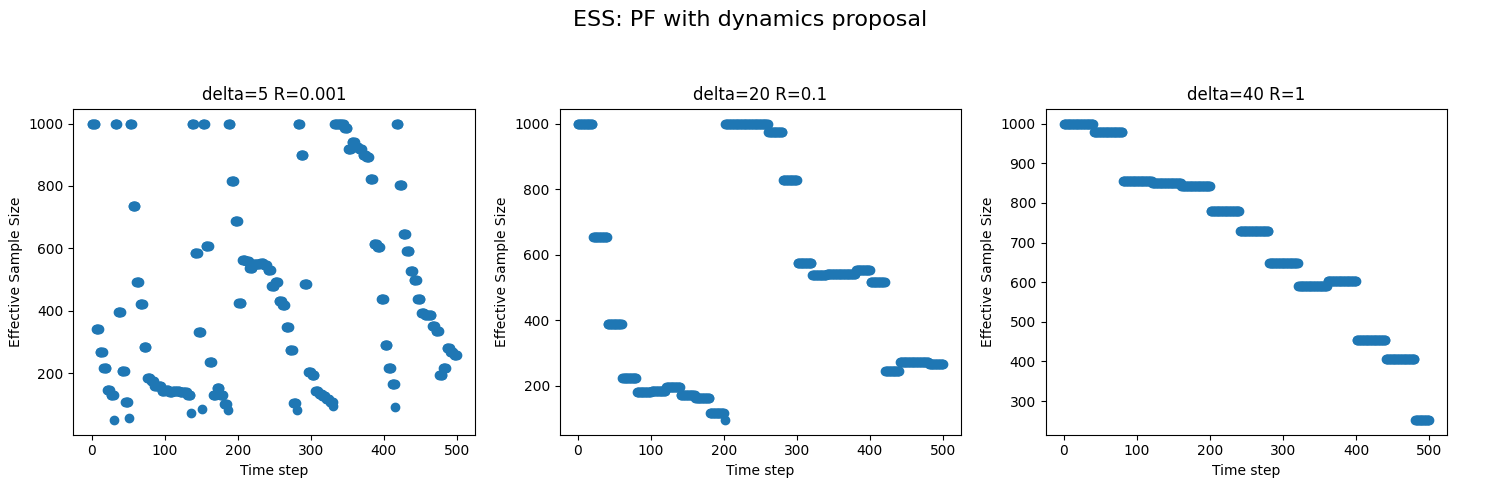

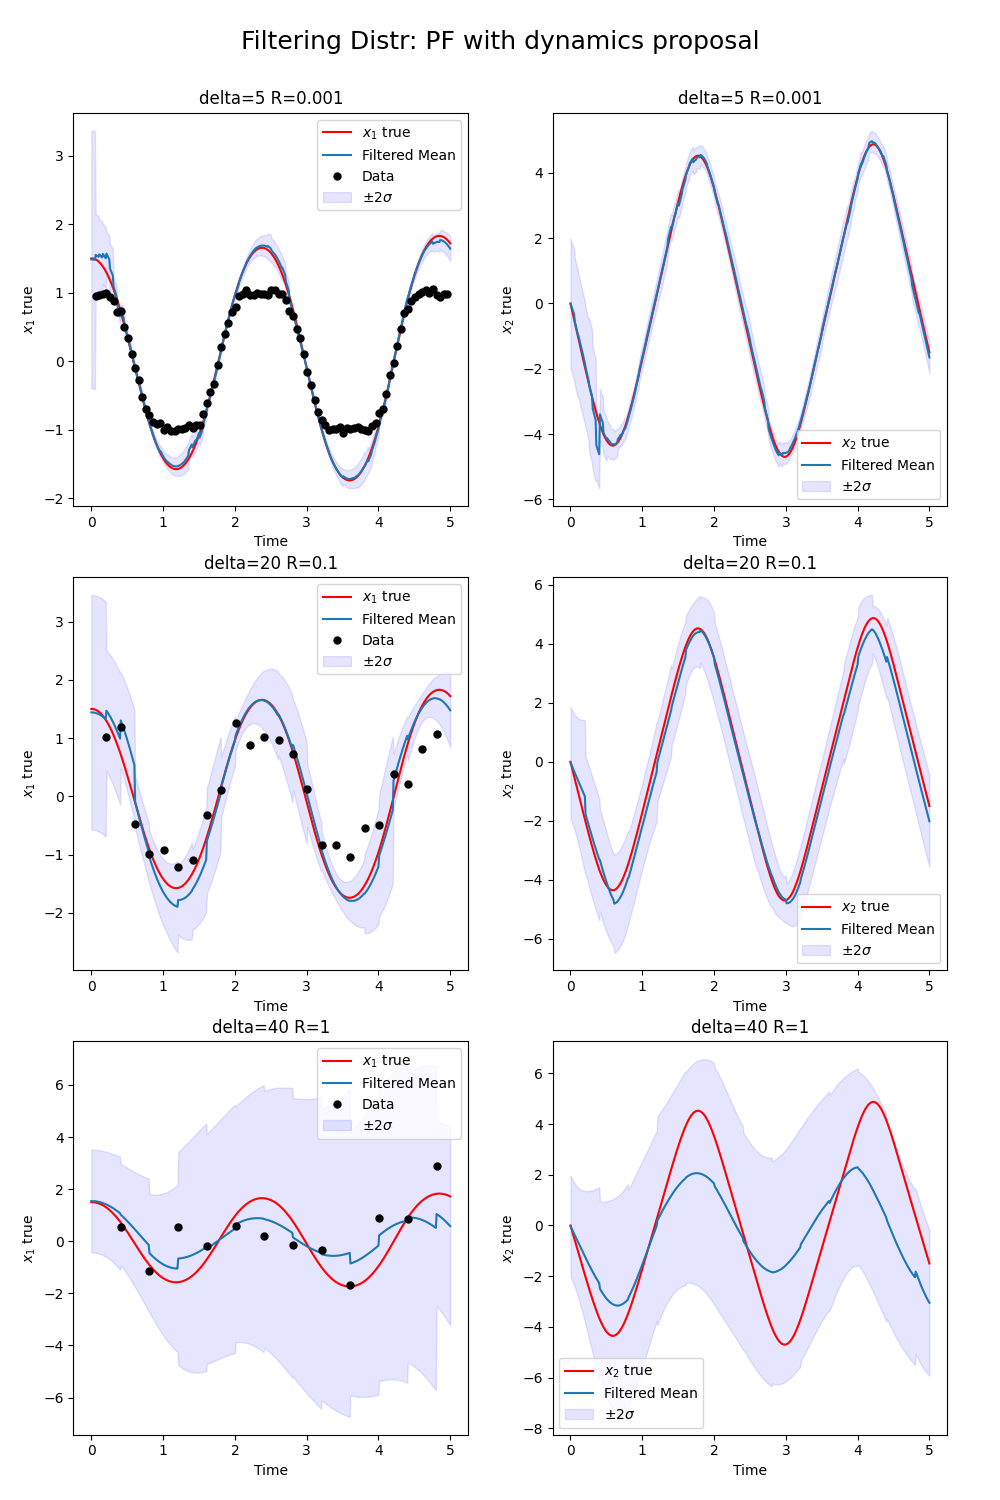

0 (2, 501)
100 (2, 501)
200 (2, 501)
300 (2, 501)
400 (2, 501)
500 (2, 501)


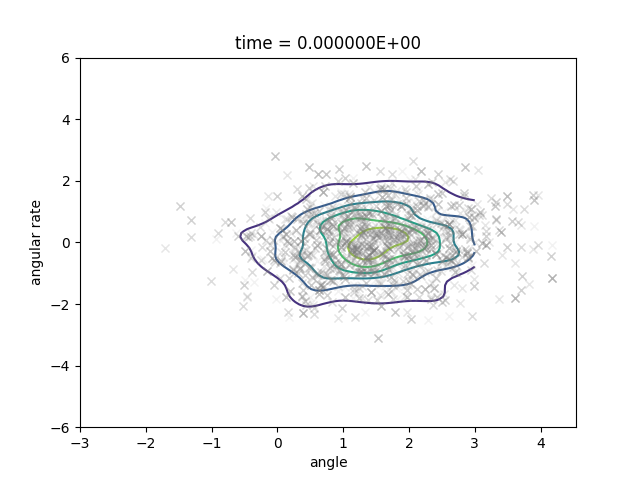

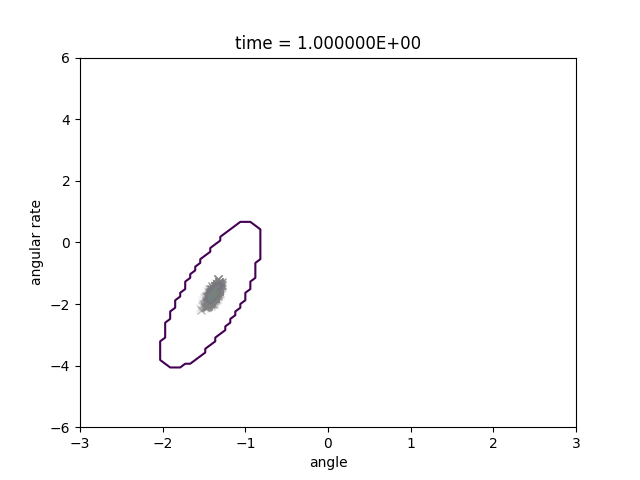

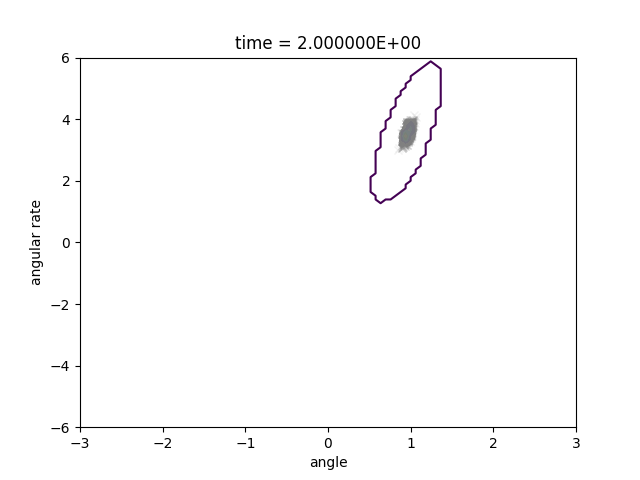

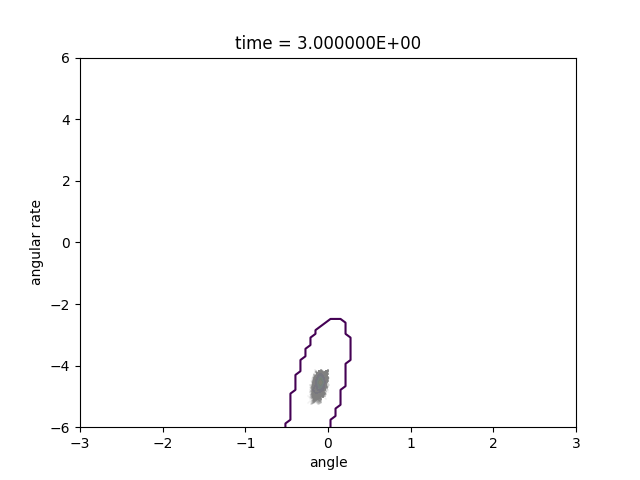

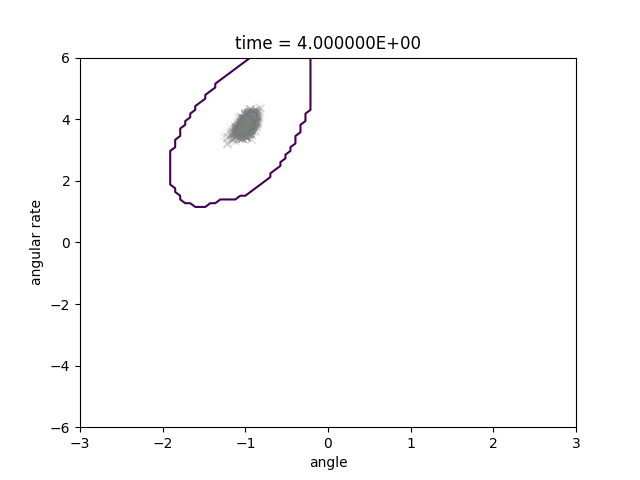

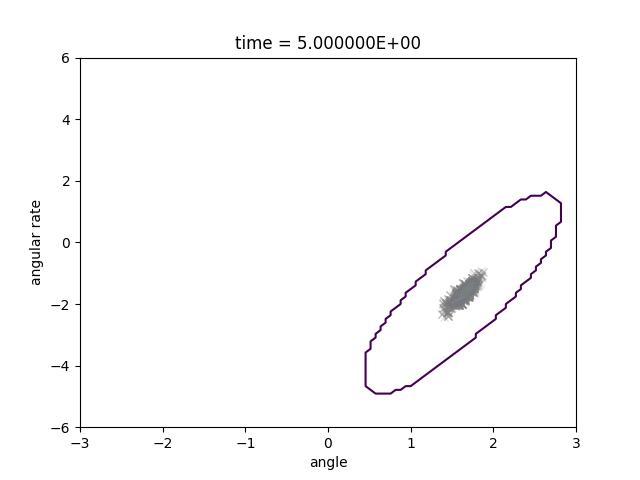

In [11]:
def plot_ess(fignum, title, results):
    plt.close(fignum)
    fig, ax = plt.subplots(1, len(results), num=fignum, figsize=(15, 5))
    fig.suptitle(f'ESS: {title}', fontsize=16)
    fig.tight_layout(pad=3)
    for ii, result in enumerate(results):
        ax[ii].plot(result.eff, 'o')
        ax[ii].set_title(f'delta={result.delta} R={result.R}')
        ax[ii].set_xlabel('Time step')
        ax[ii].set_ylabel('Effective Sample Size')
    # fig.savefig(f'figs/ess_{title}.svg')
    plt.show()
    return fignum+1


def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution.

    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights

    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations

    Notes
    -----
    m is the number of empirical distributions
    """

    N, d, m = samples.shape
    means = np.zeros((m, d))
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(
            np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds


def plot_filtering_distr(fignum, title, results, truth, data):
    plt.close(fignum)
    fig, axs = plt.subplots(3, 2, num=fignum, figsize=(10, 15))
    fig.suptitle(f'Filtering Distr: {title}', fontsize=18)
    fig.tight_layout(pad=3)
    for ii, result in enumerate(results):
        means, stds = compute_mean_std(result.samples, result.weights)
        for jj in range(2):
            ax = axs[ii, jj]
            ax.plot(truth.times, truth.obs[:, jj], '-r', label=truth.names[jj])
            ax.plot(truth.times, means[:, jj], '-', label='Filtered Mean')
            if jj == 0:
                ax.plot(data[ii].obs.times[data[ii].obs.obs_ind],
                        data[ii].obs.obs, 'ko', ms=5, label='Data')
            ax.fill_between(truth.times, means[:, jj] - 2*stds[:, jj],
                            means[:, jj] + 2*stds[:, jj], color='b', alpha=0.1, label=r'$\pm 2\sigma$')
            ax.set_title(f'delta={result.delta} R={result.R}')
            ax.set_xlabel('Time')
            ax.set_ylabel(truth.names[jj])
            ax.legend()

    # fig.savefig(f'figs/Filtering Distr: {title}.svg')
    plt.show()
    return fignum+1


def plot_2d(weights, samples, xlim, ylim):
    """A function to plot an empirical distribution"""
    Nsamples = 3000
    s, w = resample(Nsamples, samples, weights)  # resample to obtain equal weights

    xspace = np.linspace(xlim[0], xlim[1], 100)
    yspace = np.linspace(ylim[0], ylim[1], 100)
    XX, YY = np.meshgrid(xspace, yspace)

    fig, axs = plt.subplots(1, 1)

    positions = np.vstack([XX.ravel(), YY.ravel()])
    values = np.vstack([s[:, 0], s[:, 1]])
    kernel = sp.stats.gaussian_kde(values)  # kernel density estimate to get contours
    f = np.reshape(kernel(positions).T, XX.shape)
    axs.contour(XX, YY, f,)
    axs.plot(s[:, 0], s[:, 1], 'x', color='grey', alpha=0.1)
    axs.set_xlabel("angle")
    axs.set_ylabel("angular rate")

    return fig, axs


def plot_posterior(fignum, title, results):
    plt.close(fignum)
    fig, axs = plt.subplots(5, len(results), num=fignum, figsize=(15, 25), sharex=True, sharey=True)
    fig.suptitle(f'Posterior: {title}', fontsize=18)
    fig.tight_layout(pad=3)
    Nsamples = 1000
    xrange = np.linspace(-3, 3, 100)
    yrange = np.linspace(-6, 6, 100)
    xgrid, ygrid = np.meshgrid(xrange, yrange)
    positions = np.vstack([xgrid.ravel(), ygrid.ravel()])
    for i, result in enumerate(results):
        for j in range(5):
            ax = axs[j, i]
            s, _ = resample(Nsamples, result.samples[:, :, j], result.weights[:, j])
            values = np.vstack([s[:, 0], s[:, 1]])
            kernel = sp.stats.gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xgrid.shape)
            ax.contour(xgrid, ygrid, f)
            axs.plot(s[:, 0], s[:, 1], 'x', color='grey', alpha=0.1)
            ax.set_title(f'delta={result.delta} R={result.R} Time={truth.times[j]:.2f}')
            ax.set_xlabel(r'$x_1$')
            ax.set_ylabel(r'$x_2$')
    fig.savefig(f'figs/Posterior: {title}.svg')
    plt.show()
    return fignum+1


fignum = plot_ess(fignum, 'PF with dynamics proposal', pf_dyn_results)
fignum = plot_filtering_distr(fignum, 'PF with dynamics proposal', pf_dyn_results, truth, data_pf)

# xlim = [-3, 3]
# ylim = [-6, 6]
# means, stds = compute_mean_std(samples, weights)
# N, d = means.shape
# for ii in range(N):
#     if ii % 100 == 0:
#         print(ii, pf_dyn_results[0].samples[ii].shape)
#         fig, axs = plot_2d(pf_dyn_results[0].weights[:, ii],
#                            pf_dyn_results[0].samples[:, :, ii], xlim, ylim)
#         axs.set_title("time = {:5E}".format(truth.times[ii]))

In [ ]:
x = np.linspace(-1, 1, 1000)
y = np.sin(x)
plt.plot(x, y)